# Mixture Models

###### COMP4670/8600 - Statistical Machine Learning - Tutorial

In this lab, we will use expectation-maximisation to model the eruptions of the Old Faithful geyser with a two-component Gaussian mixture model. 

### Assumed knowledge
- Gaussian mixture models and expectation-maximisation (lectures)
- Normalising data

### After this lab, you should be comfortable with:
- Modelling data with a Gaussian mixture model
- Understanding why and how this model is an instance of EM
- Visualising the convergence of the Gaussian mixture model algorithm## Textbook Questions
These questions are hand picked to both be of reasonable difficulty and demonstrate what you are expected to be able to solve. The questions are labelled in Bishop as either $\star$, $\star\star$, or $\star\star\star$ to rate its difficulty.

$\newcommand{\trace}[1]{\operatorname{tr}\left\{#1\right\}}$
$\newcommand{\Norm}[1]{\lVert#1\rVert}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\inner}[2]{\langle #1, #2 \rangle}$
$\newcommand{\DD}{\mathscr{D}}$
$\newcommand{\grad}[1]{\operatorname{grad}#1}$
$\DeclareMathOperator*{\argmin}{arg\,min}$
Run this cell to set up $\LaTeX$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


## Recap of Gaussian Mixture Models

Given a collection of data $\{\mathbf{x}_1, \ldots, \mathbf{x}_n \}$, where $\mathbf{x}_i \in \mathbb{R}^D$
we assume that the data was drawn from
a probability distrubtion $p$, modelled as a mixture of $K$ many Gaussians.
$$
p(\mathbf{x}) := \sum_{k=1}^K \pi_k \mathcal{N}(x \mid \mu_k, \Sigma_k )
$$

We assume that the data $\mathbf{X} = \{\mathbf{x}_1, \ldots, \mathbf{x}_n \} \in \mathbb{R}^{N \times D}$ is known, the number of gaussians $K$ is known,
and we would like to find the parameters $\pi_k, \mu_k, \Sigma_k$.

Note that the mixture weights must satisfy
$$
\sum_{k=1}^K \pi_k = 1
$$

In practise, when we want to sample a point from $p(\mathbf{x})$, we sample a number $p$ uniformly from
the interval $[0,1)$, and then if $p$ satisfies $\sum_{i=1}^{k-1} \pi_i \leq p < \sum_{i=1}^{k} \pi_k$,
we then sample $\mathbf{x}$ from the corresponding $K^\text{th}$ gaussian $\mathcal{N}(x \mid \mu_k, \Sigma_k )$.

For example, given three gaussians, and the mixture coefficients $\pi_1,\pi_2, \pi_3 = 0.3, 0.3, 0.4$,
we draw $p$ from the half-open unit interval, see which of the three intervals 
$$[0,0.3), [0.3, 0.6), [0.6, 1)$$
$p$ lies in, and then sample $\mathbf{x}$ from the corresponding gaussian. 

### Latent Variables for GMM

For a data point $\mathbf{x}$, we define a latent variable $\mathbf{z}$, and denote the $k^\text{th}$
term in vector $\mathbf{z}$ as $z_k$. 
The latent varaible $\mathbf{z}$ is a 1-of-$K$ (or a one-hot encoding) 
indicating which gaussian the point $\mathbf{x}$ was sampled from. 
(A one-hot encoding means that one of the $z_k$'s
will be one, and the rest will be zero.)
By doing this, we can define the conditional probablity
$$
p(\mathbf{x} \mid z_k = 1) := \mathcal{N}(X \mid \mu_k, \Sigma_k)
$$

In practise, for each data point $\mathbf{x}_n$, we introduce a corresponding latent variable $\mathbf{z}_n$ 
that represents which gaussian that $\mathbf{x}_n$ came from. Of course, we don't know what the $\mathbf{z}_n$'s are, otherwise the problem would already be solved. We let $(z_n)_k$, or simply $z_{nk}$, to denote the $k^\text{th}$ term
in the $n^\text{th}$ latent variable, corresponding to the data point $\mathbf{x}_n$.
So, we should write the above as
$$
p(\mathbf{x}_n \mid z_{nk} = 1) := \mathcal{N}(X \mid \mu_k, \Sigma_k)
$$

### Responsibilities

We define
$$
\gamma (z_{nk}) := p(z_{nk} = 1 \mid \mathbf{x}_n )  
$$
which denotes how "responsible" the component $k$ of is for explaining the observation $\mathbf{x}_n$.
By Bayes' Law, we can write
\begin{align}
p(z_{nk} = 1 \mid \mathbf{x}_n )
& = \frac{p(\mathbf{x}_n \mid z_{nk} = 1) p(z_{nk} = 1)}{p(\mathbf{x}_n)} \\
& = \frac{p(z_{nk} = 1) p(\mathbf{x}_n \mid z_{nk} = 1) }{ \sum_{k=1}^K p(z_{nk} = 1) p(\mathbf{x}_n \mid z_{nk} = 1)} \\
& = \frac{\pi_{k} \mathcal{N}( \mathbf{x}_n \mid \mu_k, \Sigma_k ) }
    { \sum_{k=1}^K \pi_{k} \mathcal{N}( \mathbf{x}_n \mid \mu_k, \Sigma_k)}
\end{align}
So, we have
$$
\gamma (z_{nk}) = 
\frac{\pi_{k} \mathcal{N}( \mathbf{x}_n \mid \mu_k, \Sigma_k ) }
    { \sum_{k=1}^K \pi_{k} \mathcal{N}( \mathbf{x}_n \mid \mu_k, \Sigma_k)}
$$

#### Log Likelihood

Now, the log likelihood is given by
$$
\log p(\mathbf{x} \mid \pi, \mu, \Sigma) 
= \sum_{n=1}^N \log \left\{ \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x} \mid \mu_k, \Sigma_k) \right\}
$$
and we want to choose all the parameters $\mu, \Sigma, \pi$ to maximise the log likelihood.

#### Maximising Log Likelihood

Checking where the derivative of $\log p(\mathbf{x} \mid \pi, \mu, \Sigma)$ with respect to $\mu_k$ is zero,
we obtain
$$
0 = \sum_{n=1}^N \frac{\pi_{k} \mathcal{N}( \mathbf{x}_n \mid \mu_k, \Sigma_k ) }
    { \sum_{k=1}^K \pi_{k} \mathcal{N}( \mathbf{x}_n \mid \mu_k, \Sigma_k)} \Sigma_k^{-1}
    (\mathbf{x}_n - \mu_k)
$$
and rearranging, we obtain 
$$
\mu_k = \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk}) \mathbf{x}_n
$$
where 
$$
N_k := \sum_{n=1}^N \gamma (z_{nk})
$$
is called the effective number of points assigned to the $k^\text{th}$ gaussian.
(**Exercise (after the coding): verify this**)

Similarly, taking the derivative with respect to $\Sigma_k$,
we obtain
$$
\Sigma_k = \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk}) (\mathbf{x}_n - \mu_k) (\mathbf{x}_n - \mu_k)^T
$$

and taking the derivative with respect to $\pi_k$ 
$$
\pi_k = N_k / N
$$
where the method of Lagrange multipliers is used to maximise w.r.t. the constraint $\sum_{k=1}^K \pi_k = 1$ (as otherwise the maximisation is trivial and unhelpful). (**Exercise (after the coding): verify this**)

Now, the problem is that $\gamma(z_{nk})$ is dependant on the parameters $\mu, \Sigma, \pi$, but
those parameters in turn depend on the responsibilities $\gamma(z_{nk})$. This means that we don't have
our paramters in closed form.

#### Expectation-Maximisation (EM) Algorithm

We use the EM algorithm to numerically find good values for the parameters $\mu, \Sigma, \pi$,
that maximise the log likelihood.

##### Step 1 (Initialise)

Initialise the parameters $\mu_k, \Sigma_k, \pi_k$, and evaluate the log-likelihood.

##### Step 2 (Estimation)

Compute the responsibilities (which depend on the parameters)
$$
\gamma(z_{nk}) := \frac{\pi_{k} \mathcal{N}( \mathbf{x}_n \mid \mu_k, \Sigma_k ) }
    { \sum_{k=1}^K \pi_{k} \mathcal{N}( \mathbf{x}_n \mid \mu_k, \Sigma_k)}
$$

##### Step 3 (Maximisation)

Compute the parameters (which depend on the responsibilities)

\begin{align}
N_k^\text{new} & := \sum_{n=1}^N \gamma(z_{nk}) \\
\pi_k^{\text{new}} & := \frac{N_k^\text{new}}{N} \\
\mu_k^\text{new} & := \frac{1}{N_k^\text{new}} \sum_{n=1}^N \gamma(z_{nk}) \mathbf{x}_n \\
\Sigma_k^\text{new} & := \frac{1}{N_k^\text{new}} \sum_{n=1}^N \gamma(z_{nk}) (\mathbf{x}_n - \mu_k^\text{new}) (\mathbf{x}_n - \mu_k^\text{new})^T
\end{align}

##### Step 4 (Evaluate)

Compute the log-likelihood, if it has no converges, goto 2.
$$
\log p(\mathbf{x} \mid \pi, \mu, \Sigma) 
= \sum_{n=1}^N \log \left\{ \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x} \mid \mu_k, \Sigma_k) \right\}
$$


#### Summary of Variables
| Variable |     Type   |  Description| Known? |
|---|---|---|---|
| $$N$$ 			 |   $$\mathbb{N}$$ | Number of data points | Yes |
| $$D$$ 				| $$\mathbb{N}$$				| Dimension of data points | Yes |
| $$K$$				| $$\mathbb{N}$$				| Number of gaussians | Yes |
| $$\mathbf{x}_n$$ | $$\mathbb{R}^D$$ 	| A data point | Yes |
| $$X$$            | $$\mathbb{R}^{N \times D}$$ 	| Data matrix | Yes |
| $$\mathbf{z}_n$$ | $$\{0,1\}^K$$		        | Latent variable, a one-hot encoding of which gaussian $\mathbf{x}_n$ was sampled from. | No |
| $$(z_n)_k, z_{nk}$$      | $$\{0,1\}$$				| $k^\text{th}$ term in the $n^\text{th}$ latent variable $\mathbf{z}_n$. | No |
| $$Z$$            | $$\{0,1\}^{N \times K}$$ 	| Latent matrix | No |
| $$\gamma_{z_{nk}}$$ | $$\mathbb{R}$$ | The responsibility for the $k$ component to explain the observation $\mathbb{x}_n$. | No|
| $$N_k$$ | $$\mathbb{N}$$ | The effective number of points assigned to the $k^\text{th}$ gaussian. | No | 
| $$\pi_k$$ 		| $$\mathbb{R}$$ 			    | The mixture weighting on the $k^\text{th}$ gaussian. | No |
| $$\mu_k$$ 		| $$\mathbb{R}^D$$ 			| The mean of the $k^\text{th}$ gaussian. | No |
| $$\Sigma_k$$ 	| $$\mathbb{R}^{D \times D}$$ | The covariance of the $k^\text{th}$ gaussian. | No |
| $$\pi$$ | $$\mathbb{R}^{K}$$ | A vector of all the gaussian mixture weightings $\pi_1, \ldots, \pi_K$. | No|
| $$\mu$$ | $$\mathbb{R}^{K \times D}$$ | A matrix of all the gaussian means $\mu_1, \ldots, \mu_K$. | No |
| $$\Sigma$$ | $$\mathbb{R}^{K \times D \times D}$$ | A 3-tensor of all the gaussian covariances $\Sigma_1, \ldots, \Sigma_K$. | No|

## Get the data

Ensure you have the dataset for this week.
The data is a collection of two dimensional data points, and describes eruptions of the Old Faithful geyser in Yellowstone National Park, Wyoming, US.
The two features are the waiting time between eruptions and the duration of the eruption.
Load the data and normalise the features to have
zero mean and unit variance.

In [2]:
# load the old faithful dataset
data = np.loadtxt('07-dataset.csv', delimiter=',')
data_labels = ('Eruption length','Eruption wait')

# and standardise
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)

assert data.shape == (272, 2)

Create variables ``mu_0``, ``pi_0`` and ``Sigma_0`` to store the initial parameters of the Gaussian mixture model for the data. Our mixture model will be made up of two gaussians, and will be initialised with means
$$
\mu_1 =
\begin{bmatrix}
    -1\\+1
\end{bmatrix}
\qquad
\mathrm{and}
\qquad
\mu_2 =
\begin{bmatrix}
    +1\\-1
\end{bmatrix}
$$
respectively.

The covariance matricies should be initialised to the identity matrix, and the mixture should start off with equal probability.

As a reminder, `pi_0` is a vector of all the mixture weights initially,
`mu_0` is a matrix of all the means initially, and `Sigma_0` is a 3-tensor of the covariances initially.


In [5]:
# Solution
pi_0 = np.array([0.5,0.5]) # TODO
mu_0 = np.array([
    [-1, 1],
    [1, -1]
]) # TODO
Sigma_0 = np.array([
    np.identity(2)
]*2)


## Plotting the data

To help visualise the EM process, we will plot the data and ellipses representing our two Gaussian components.

The next cell provides some helper functions for this plotting.

In [6]:
# plot_cov_ellipse was taken from here:
# http://www.nhsilbert.net/source/2014/06/bivariate-normal-ellipse-plotting-in-python/

def plot_cov_ellipse(cov, pos, volume=.5, ax=None, fc='none', ec=[0,0,0], a=1, lw=2):
    """
    Plots an ellipse enclosing *volume* based on the specified covariance
    matrix (*cov*) and location (*pos*). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        volume : The volume inside the ellipse; defaults to 0.5
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
    """

    import numpy as np
    from scipy.stats import chi2
    import matplotlib.pyplot as plt
    from matplotlib.patches import Ellipse

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':a, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * np.sqrt(chi2.ppf(volume,2)) * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)

    ax.add_artist(ellip)
    

def plot_components(mu, Sigma, colours, *args, **kwargs):
    '''
    Plot ellipses for the bivariate normals with mean mu[:,i] and covariance Sigma[:,:,i]
    '''
    assert mu.shape[1] == Sigma.shape[2]
    assert mu.shape[0] == 2
    assert Sigma.shape[0] == 2
    assert Sigma.shape[1] == 2
    for i in range(mu.shape[1]):
        kwargs['ec'] = colours[i]
        plot_cov_ellipse(Sigma[i], mu[i], *args, **kwargs)

import matplotlib.colors as mcol

br_cmap = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])

def plot_data(redness=None):
    if redness is not None:
        assert len(redness) == data.shape[1]
        assert all(_ >= 0 and _ <= 1 for _ in redness)
        c = redness
    else:
        c = 'g'
    plt.figure(figsize=(8,8))
    plt.scatter(data[:,0],data[:,1], marker='.', s=8, linewidths=2, c=c, cmap=br_cmap)
    plt.xlabel(data_labels[0])
    plt.ylabel(data_labels[1])
    plt.axis([-2,2,-2,2])
    plt.axis('equal')


The following cell is an example of using these functions. It should plot the data and two ellipses representing your initial Gaussian clusters.

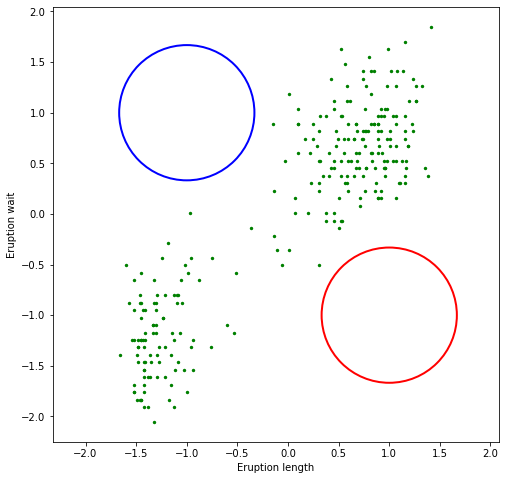

In [7]:
if 'mu_0' in locals() and 'Sigma_0' in locals() and 'data' in locals(): # check the student has defined these vars

    plot_data()
    plot_components(mu_0, Sigma_0, ['b','r'], 0.2)
    plt.show()

## Optimising the Gaussian mixture model with EM

As discussed in Lectures, we can optimise the Gaussian mixture model with expectation-maximisation,
and perform maximum likelihood estimation for $\mathbf{\mu}$, $\mathbf{\Sigma}$ and $\mathbf{\pi}$.

First implement functions that perform the E-step and the M-step.
We suggest the following function signatures:

```def e_step(X, mu, Sigma, pi):```

and

```def m_step(X, gamma):```

Hint: You can use 

```from scipy.stats import multivariate_normal as mvnorm```

```mvnorm.pdf(x, mu, sigma)```

to compute $\mathcal{N}(\mathbf{x}_N \mid \mu_k, \Sigma_k)$.

Then make a helper function ```weight_norm(X, mu, Sigma, pi)``` that calculates a $N\times K$ matrix of weighted normal probabilities $\pi_{k} \mathcal{N}( \mathbf{x}_n \mid \mu_k, \Sigma_k)$.


In [9]:
# Solution

from scipy.stats import multivariate_normal as mvnorm
def weighted_normals(X, mu, Sigma, pi):
    # Calculates the numerator of the gamma_i's, i.e. the 
    # weighted normal probabilities of each data point.
    # Can use mvnorm.pdf for the normal probabilities
    w_norms = pi @ multivariate_normal.pdf(X, mean=mu, cov=Sigma)
    return w_norms # (N,K)

def e_step(X, mu, Sigma, pi):
    weighted_normals(X, mu, Sigma, pi)/np.sum(weighted_normals(X, mu, Sigma, pi), axis=1)[:,None]
    return gamma # (N, K)

def m_step(X, gamma):
    
    return new_mu, new_Sigma, new_pi # (K,D), (K,D,D), (K,)

NameError: name 'mu' is not defined

## Evaluating the model

Write a function to calculate the log-likehood of your model for given parameters for the Gaussian distribution

In [ ]:
# Solution
def log_likelihood(X, mu, Sigma, pi):
    
    return ll

Plot the log-likehood of your model against the number of updates made to it. Does it converge?

In [ ]:
mu = mu_0
Sigma = Sigma_0
pi = pi_0

trials = 100
ll = np.zeros(trials)
for i in range(0,trials):
    ll[i] = log_likelihood(data, mu, Sigma, pi)
    gamma = e_step(data, mu, Sigma, pi)
    (mu, Sigma, pi) = m_step(data, gamma)

plt.title("Log-Likelihoods from iter 0")
plt.xlabel("Number of updates")
plt.plot(ll)
plt.show()

plt.title("Log-Likelihoods from iter 1")
plt.xlabel("Number of updates")
plt.plot(ll[1:])
plt.show()

## Visualising EM
Use ``plot_data`` and ``plot_components`` to plot the data and your current Gaussian distributions for a range of number of updates. Does the model change as you would expect?

In [ ]:
mu = mu_0
Sigma = Sigma_0
pi = pi_0

trials = 50
ll = np.zeros(trials)
for i in range(0,trials):
    ll[i] = log_likelihood(data, mu, Sigma, pi)
    if(i % 5 == 0):
        plot_data()
        plot_components(mu, Sigma, ['b','r'], 0.2)
        plt.title("Iter {}: ll={}".format(i, ll[i]))
        plt.show()
        
    gamma = e_step(data, mu, Sigma, pi)
    (mu, Sigma, pi) = m_step(data, gamma)

## Understanding the theory

### Exercise 1: Conceptual understanding
Refer to Bishop and/or the lecture slides, and explain with equations:
1. the assumed generative data generating process for the mixture of Gaussians,
- what the parameters of the model are,
- what the latent (unobserved) variables are and why they make maximum likelihood parameter estimation non-trivial,
- how EM provides a solution to the maximum likelihood estimation problem.

### Exercise 2: Deriving the update equations

#### Bishop Exercise 9.7

Verify that maximization of the complete-data log likelihood
\begin{align}
\ln p(\mathbf{X},\mathbf{Z}|\mathbf{\mu},\mathbf{\Sigma},\mathbf{\pi}) 
& = 
\sum_{n=1}^N \sum_{k=1}^K z_{nk} \{ \ln \pi_k + \ln \mathcal{N}(\mathbf{x}_n | \mathbf{\mu}_k, \mathbf{\Sigma}_k \},
\end{align}
for a Gaussian mixture model leads to the result that the means and covariances of each component are fitted independently to the corresponding group of data points, and the mixing coefficients are given by the fractions of points in each group.

#### Bishop Exercise 9.8

Show that if we maximize
\begin{align}
\mathbb{E}_\mathbf{Z} \left[ \ln p(\mathbf{X},\mathbf{Z}|\mathbf{\mu},\mathbf{\Sigma},\mathbf{\pi}) \right]
& = 
\sum_{n=1}^N \sum_{k=1}^K \gamma(z_{nk}) \{ \ln \pi_k + \ln \mathcal{N}(\mathbf{x}_n | \mathbf{\mu}_k \mathbf{\Sigma}_k \},
\end{align}
with respect to $\mathbf{\mu}_k$ while keeping the responsibilities $\gamma(z_{nk})$ fixed, we obtain the closed form solution
\begin{align}
\mathbf{\mu}_k & = \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk}).
\end{align}

#### Bishop Exercise 9.9

Show that if we instead maximize with respect to $\mathbf{\Sigma}_k$ and $\mathbf{\pi}$ while keeping the responsibilities $\gamma(z_{nk})$ fixed, we obtain the closed form solution
\begin{align}
\mathbf{\Sigma}_k 
& = 
\frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk}) (\mathbf{x}_n-\mathbf{\mu}_k)(\mathbf{x}_n-\mathbf{\mu}_k)^\top, \\
\pi_k &= \frac{N_k}{N}.
\end{align}

## Extra Textbook Questions
These questions are hand picked to both be of reasonable difficulty and demonstrate what you are expected to be able to solve. The questions are labelled in Bishop as either $\star$, $\star\star$, or $\star\star\star$ to rate its difficulty.


- **Question 9.2**: ($\star$) This requires the Robbins-Monro sequential estimation described in 2.3.5. The derivative of w.r.t. $\boldsymbol{\mu}$ is the M-step to compute $\boldsymbol{\mu}$. Note that $\eta$ in (9.5) represents a constant.

- **Question 9.6**: ($\star$) There is a change from $\boldsymbol{\Sigma}_k$ to $\boldsymbol{\Sigma}$ for every $k$.

- **Question 9.10**: ($\star\star$) Hint: state the property of conditional probability density function $p({x}_a \mid {x}_b)$.

- **Question 9.12**: ($\star$) Hint: $\mathbb{E}[\boldsymbol{x}] = \int \boldsymbol{x} p(\boldsymbol{x}) dx$.

- **Question 9.15**: ($\star$) Show that M-step equation (9.59) can be derived from (9.55) w.r.t. $\boldsymbol{\mu}_k$. Please revisit Bernoulli distribution in 9.3.3.

- **Question 9.16**: ($\star$) Show that M-step equation (9.60) can be derived from (9.55) w.r.t. $\pi_k$. Lagrange multipliers for $\pi_k$ is required. Please revisit Bernoulli distribution in 9.3.3.

- **Question 9.13**: ($\star\star$) This question requires (9.48) - (9.60).

- **Question 9.23**: ($\star$) It is restricted to stationary points of the objective function. The optimization has converged in this case.

- **Question 9.25**: ($\star\star$) (9.70), (9.71), and (9.72) can be used to show the lower bound.